In [ ]:
from sklearn import linear_model

import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np      


In [1]:
import matplotlib.pyplot as plt
import torch as tc
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import numpy as np

# v= Constante

## ML

In [ ]:
def eq_movimento(x_0,v_,t_): 
    return  x_0 + v_*t_

t = np.linspace(0,10)  

plt.plot(t,eq_movimento(x_0=0,v_=2,t_=t),".")
plt.plot(t,eq_movimento(x_0=0,v_=1,t_=t),".")
plt.plot(t,eq_movimento(x_0=1,v_=1,t_=t),".")

plt.show()

In [ ]:
t = np.linspace(0,10).reshape((-1, 1))  
y = eq_movimento(x_0=0,v_=2,t_=t)

reg = linear_model.LinearRegression()
reg.fit(t,y)# FITANDO 
print("a: ",reg.coef_)
print("b: ",reg.intercept_)


In [ ]:
from sklearn.tree import DecisionTreeRegressor

RT = DecisionTreeRegressor(criterion = "squared_error")
RT.fit(t,y)# FITANDO 

t_tes = np.linspace(0,10).reshape((-1, 1))  
predição = RT.predict(t_tes)

plt.plot(t,y,"-")
plt.plot(t_tes,predição,".")

plt.show()

## NN

In [20]:
class Regressao(nn.Module):
    def __init__(self,neuronio):
        super().__init__()
        self.layer_1 = nn.Linear(1,neuronio)
        self.layer_3 = nn.Linear(neuronio,1)
        self.A_layer = nn.ReLU()

    def forward(self, x):
        x = self.A_layer(self.layer_1(x))
        x = self.A_layer(self.layer_3(x))
        return x  

In [48]:
class Loss_parametro(nn.Module):
    def __init__(self):
        super(Loss_parametro, self).__init__()
    def forward(self, inputs, targets,outputs):
        # mudar de [N,1] para [N]
        # função 1° grau: x- x0 -vt = 0
        funcao_1_grau = targets - targets[0] - outputs*inputs
        loss_solution = tc.mean( abs(funcao_1_grau) )
        # podemos impor que independe do input o parametro deve ser igual  
        # v_medio = output[:,1].mean()
        # loss_const = tc.mean((output[:,1] - v_medio) ** 2)
        return loss_solution
    
class Loss_edo(nn.Module):
    def __init__(self,rede_neural,velocidade):
        super(Loss_edo, self).__init__()
        self.rede = rede_neural
        self.v = velocidade
        
    def forward(self, inputs, targets):
        output ,derivadas = tc.autograd.functional.jvp(self.rede ,inputs ,v=tc.ones(len(inputs),1),create_graph=True) # v é um vetor unitario para retorna apenas o jacobiano
        # condição inicial x(0)
        loss_ic = (output[0] - targets[0])**2
        
        # dividido pela tamanho do dados de entrada
        loss_ic = loss_ic/len(inputs)
        # Derivada da função em relação a entrada 
        # edo : dx/dt = v
        # estamos usando [1:] para escluir a condição inicial
        loss_edo = tc.mean( (derivadas[1:] - self.v )**2 )

        return loss_ic + loss_edo

Usando a loss edo 

| Train Loss: 0.003917781636118889 |


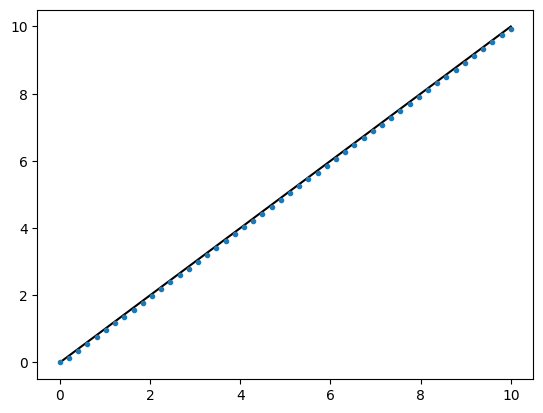

In [38]:
def eq_movimento(x_0,v_,t_): 
    return  x_0 + v_*t_

# Criando os dados de treino
x_train = tc.linspace(0,10,50).reshape(50,1)
y_train =  eq_movimento(x_0=0,v_=1,t_=x_train)

rede1 = Regressao(20) # rede da função
opt1 = tc.optim.Adam(params=rede1.parameters(),lr=0.01)  # rede da função
loss_fn1  = Loss_edo(rede1,velocidade=1)

epochs = 10000
for epoch in range(epochs):
    rede1.train()
    loss = loss_fn1(x_train, y_train)
    opt1.zero_grad()
    loss.backward()
    opt1.step() 

#rede 1 é a função
loss_fn = nn.MSELoss()
rede1.eval()
with tc.inference_mode():
    prediçao = rede1(x_train)
    loss = loss_fn( prediçao,y_train)
    print(f"| Train Loss: {loss} |")
    
plt.plot(x_train,y_train,"k-" ,label="teorico")
plt.plot(x_train, prediçao,".",label="predição" )
plt.legend()
plt.show()  

| Train Loss: 0.00031880204915069044 |
tensor([[0.9623],
        [0.9778],
        [0.9865],
        [0.9951],
        [0.9973]])


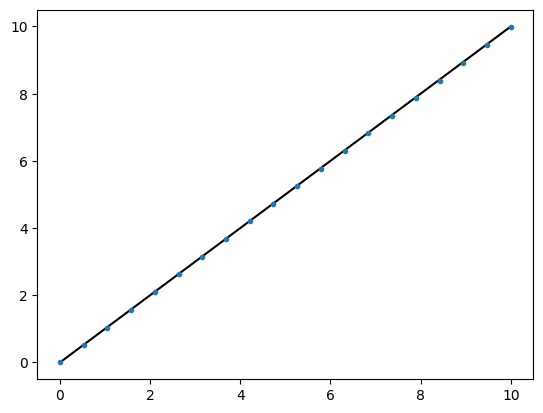

In [50]:
def eq_movimento(x_0,v_,t_): 
    return  x_0 + v_*t_

# Criando os dados de treino
x_train = tc.linspace(0,10,20).reshape(20,1)
y_train =  eq_movimento(x_0=0,v_=1,t_=x_train)


rede2 = Regressao(10) # rede dos parametros 
opt2 = tc.optim.Adam(params=rede2.parameters(),lr=0.01) # rede dos parametros 
loss_fn2  = Loss_parametro()

epochs = 10000
for epoch in range(epochs):
    rede2.train()
    y_preds = rede2(x_train)
    loss = loss_fn2(inputs=x_train,targets=y_train, outputs=y_preds)
    opt2.zero_grad()
    loss.backward()
    opt2.step() 
    
    
    rede1.train()
    loss = loss_fn1(x_train, y_train)
    opt1.zero_grad()
    loss.backward()
    opt1.step() 

#rede 2 é a parametro
loss_fn = nn.MSELoss()
rede2.eval()
with tc.inference_mode():
    prediçao = rede2(x_train)
    loss = loss_fn(y_train[0] + prediçao*x_train,y_train)
    print(f"| Train Loss: {loss} |")
    print(prediçao[:5])
plt.plot(x_train,y_train,"k-" ,label="teorico")
plt.plot(x_train,y_train[0] + prediçao*x_train,".",label="predição" )
plt.show()  

# a =Constante

In [ ]:
def eq_movimento(x_0,v_,a_,t_):
    return  x_0 + v_*t_ + a_*t_**2/2

t = np.linspace(0,1.4).reshape((-1, 1))    
y = eq_movimento(x_0=10,v_=0,a_=-9.81,t_=t)
plt.plot(t,y,".")
plt.show()

Regressão linear

In [ ]:
reg = linear_model.LinearRegression()
reg.fit(t,y)# FITANDO 
print("a: ",reg.coef_)
print("b: ",reg.intercept_)

plt.plot(t,y,".")
plt.plot(t,reg.intercept_[0] + reg.coef_[0][0]*t,".")
plt.show()

Decision tree

In [ ]:
from sklearn.tree import DecisionTreeRegressor

RT = DecisionTreeRegressor(criterion = "squared_error")
RT.fit(t,y)# FITANDO 


predição = RT.predict(t)

plt.plot(t,y,"-")
plt.plot(t,predição,".")

plt.show()

Regressaõ polinomia 

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model

poly = PolynomialFeatures(degree=2)

t_poly = poly.fit_transform(t)

R = linear_model.LinearRegression()
train_y_ = R.fit(t_poly, y)
# The coefficients
print ('Coefficients: ', R.coef_)
print ('b: ',R.intercept_)

predição = R.intercept_[0]+ R.coef_[0][1]*t+ R.coef_[0][2]*t**2
plt.plot(t,y,"-")
plt.plot(t,predição,".")

plt.show()

Rede neural 

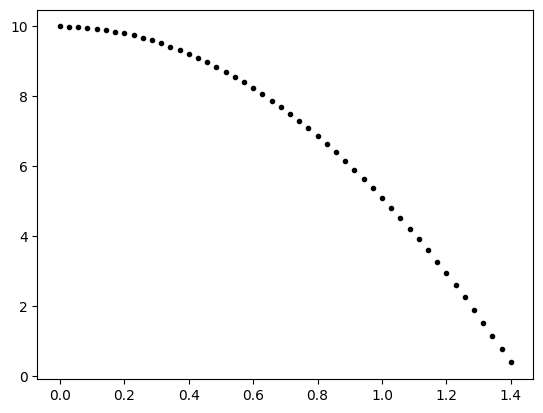

In [51]:
def eq_movimento(x_0,v_,a_,t_):
    return  x_0 + v_*t_ + a_*t_**2/2


# Criando os dados de treino
x_train = tc.linspace(0,1.4,50).reshape(50,1)
y_train =  eq_movimento(x_0=10,v_=0,a_=-9.81,t_=x_train)

# Visualizando os dados de treino

plt.plot(x_train,y_train,"k." )
plt.show()

Aprendendo a função com os dados 

| Train Loss: 0.0025445977225899696 | 


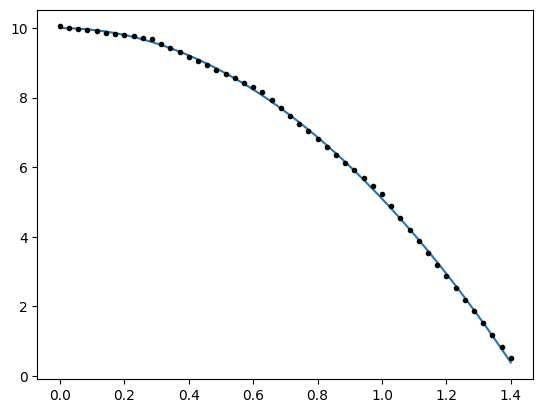

In [53]:
# Construindo o modelo
class Regressao(nn.Module):
    def __init__(self,neuronio):
        super().__init__()
        self.layer_1 = nn.Linear(1,neuronio)
        self.layer_3 = nn.Linear(neuronio,1)
        self.A_layer = nn.ReLU()
        
    def forward(self, x):
        x = self.A_layer(self.layer_1(x))
        x = self.A_layer(self.layer_3(x))
        return x
    
model = Regressao(neuronio=30)
loss_fn = nn.MSELoss()
optimizer = tc.optim.Adam(params=model.parameters(),lr=0.01)

epochs = 10000
for epoch in range(epochs):
    model.train()
    y_preds = model(x_train)
    loss = loss_fn(y_preds, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

model.eval()
with tc.inference_mode():
    y_preds_test = model(x_train)
    loss = loss_fn(y_preds_test,y_train)
    print(f"| Train Loss: {loss} | ")

plt.plot(x_train,y_train,"-" )
plt.plot(x_train,y_preds_test,"k." )
plt.show()

aprendendo o parametro da equação(Aceleração)

| Train Loss: 1.3209441873662797e-10 | 


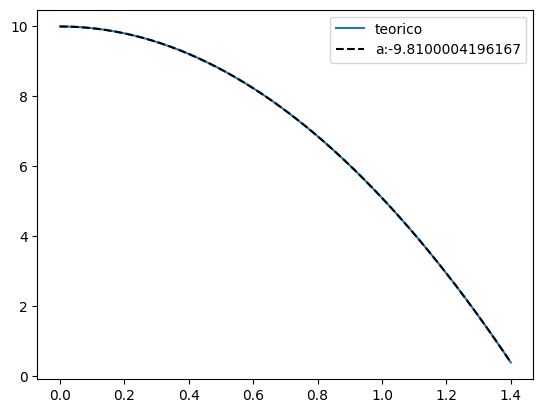

In [54]:
class Regressao(nn.Module):
    def __init__(self,neuronio):
        super().__init__()
        self.layer_1 = nn.Linear(1,neuronio)
        self.layer_2 = nn.Linear(neuronio,neuronio)
        self.layer_3 = nn.Linear(neuronio,2)
        self.A_layer = nn.ReLU()
        self.B_layer = nn.Tanh()  
        
    def forward(self, x):
        x = self.B_layer(self.layer_1(x))
        x = self.A_layer(self.layer_2(x))
        #x = self.A_layer(self.layer_3(x))
        x = self.layer_3(x)
        return x
class CustomLoss(nn.Module):
    def __init__(self,x_0,v_0):
        super().__init__()
        self.x0 = x_0
        self.v0 = v_0
        
    def forward(self, outputs, y_,t_):
        # talvez adicionar a derivada 
        # y  =  x_0 + v_*t_ + a_*t_**2/2
        return 1*tc.mean((y_ - self.x0 -self.v0*t_ - outputs[0,1]*t_**2/2)** 2) # +1*tc.mean( (y_- outputs[:,0])**2 )
    
model = Regressao(neuronio=2)
loss_fn = CustomLoss(x_0=10,v_0=0)
optimizer = tc.optim.Adam(params=model.parameters(),lr=0.01)

epochs = 5000
for epoch in range(epochs):
    model.train()

    y_preds = model(x_train)
    loss = loss_fn(y_preds, y_train,x_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

model.eval()

with tc.inference_mode():
    y_preds_test = model(x_train)
    loss = loss_fn(y_preds_test,y_train,x_train)

    print(f"| Train Loss: {loss} | ")

plt.plot(x_train,y_train,"-", label="teorico")
plt.plot(x_train,10 + y_preds_test[0,1]*x_train**2/2,"k--", label=f"a:{tc.round(y_preds_test[0,1],decimals=2)}" )
#plt.plot(x_train,y_preds_test[:,0],"r--", label="funçãoda rede" )
plt.legend()
plt.show()